In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

#Uncomment the below lines if you didn't install xRBM using pip and want to use the local code instead 
#import sys
#sys.path.append('../')

In [2]:
import xrbm.models
import xrbm.train
import xrbm.losses

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
TIMESTEPS = 3

NUM_DIM   = 4
FREQS     = [20, 35, 50, 70]
AMPS      = [4, 1, 0.5, 2.5]
NSAMPLE   = 100
SEQ_LEN   = 2000

time_data = np.arange(SEQ_LEN) / 50

X_train   = []

print('Making dummy time series...')
for i in range(NSAMPLE):
    x = [np.float32(
            np.sin(freq * time_data + np.random.rand()/2) *  
            (amp+np.random.rand())) 
         for freq, amp in zip(FREQS, AMPS)]
    
    x = np.asarray(x)
    x = x + np.random.rand(x.shape[0], x.shape[1]) * 1.2
    
    X_train.append(x.T)

X_train = np.asarray(X_train)

print(X_train.shape)

Making dummy time series...
(100, 2000, 4)


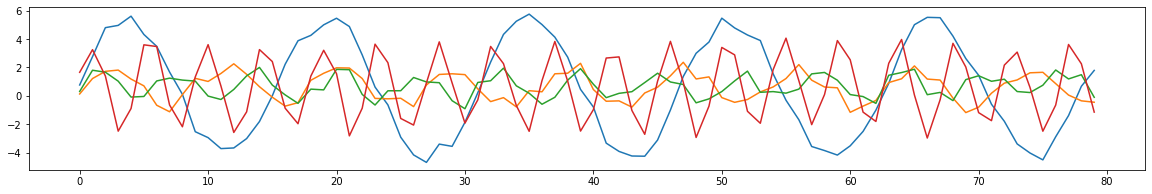

In [4]:
_=plt.figure(figsize=(20,3))
_=plt.plot(X_train[0,0:80,:])

(-6.0, 6.0)

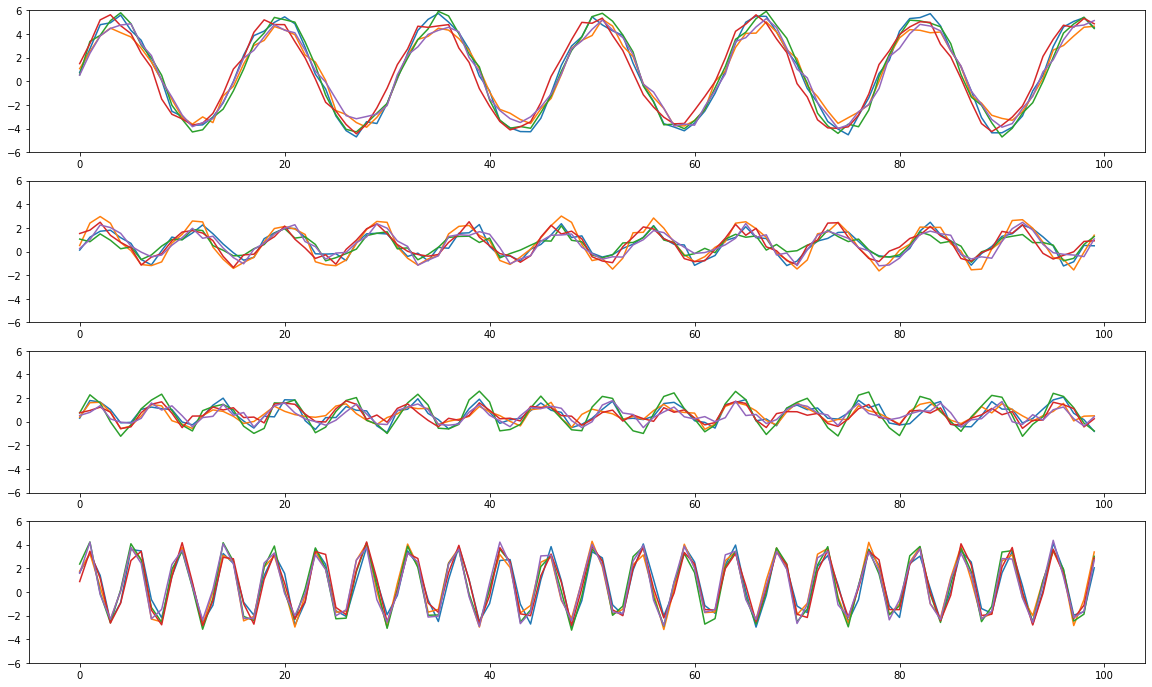

In [5]:

fig=plt.figure(figsize=(20,12))

fig.add_subplot(411)
_=plt.plot(X_train[0:5,0:100,0].T)
plt.ylim(-6, 6)

fig.add_subplot(412)
_=plt.plot(X_train[0:5,0:100,1].T)
plt.ylim(-6, 6)

fig.add_subplot(413)
_=plt.plot(X_train[0:5,0:100,2].T)
plt.ylim(-6, 6)

fig.add_subplot(414)
_=plt.plot(X_train[0:5,0:100,3].T)
plt.ylim(-6, 6)

In [6]:
X_train_flat = np.concatenate([m for m in X_train], axis=0)
data_mean = np.mean(X_train_flat, axis=0)
data_std = np.std(X_train_flat, axis=0)

X_train_normalized = [(d - data_mean) / data_std for d in X_train]

In [7]:
condition_data = []
visible_data = []

for m in X_train_normalized:
    for i in range(len(m)-TIMESTEPS):
        condition_data.append(m[i:i+TIMESTEPS].flatten())
        visible_data.append(m[i+TIMESTEPS])
        
condition_data = np.asarray(condition_data)
visible_data = np.asarray(visible_data)

In [8]:
num_vis         = visible_data.shape[1]
num_cond        = condition_data.shape[1]
num_hid         = 50
learning_rate   = 0.01
batch_size      = 100
training_epochs = 30

In [9]:
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

crbm = xrbm.models.CRBM(num_vis=num_vis,
                        num_cond=num_cond,
                        num_hid=num_hid,
                        vis_type='gaussian',
                        initializer=tf.contrib.layers.xavier_initializer(),
                        name='crbm')

In [10]:
batch_idxs = np.random.permutation(range(len(visible_data)))
n_batches  = len(batch_idxs)

In [11]:

batch_vis_data     = tf.placeholder(tf.float32, shape=(None, num_vis), name='batch_data')
batch_cond_data    = tf.placeholder(tf.float32, shape=(None, num_cond), name='cond_data')
momentum           = tf.placeholder(tf.float32, shape=())

In [12]:
cdapproximator     = xrbm.train.CDApproximator(learning_rate=learning_rate,
                                           momentum=momentum,
                                           k=1) # perform 1 step of gibbs sampling

train_op           = cdapproximator.train(crbm, vis_data=batch_vis_data, in_data=[batch_cond_data])

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [13]:
reconstructed_data,_,_,_ = crbm.gibbs_sample_vhv(batch_vis_data, [batch_cond_data])
xentropy_rec_cost  = xrbm.losses.cross_entropy(batch_vis_data, reconstructed_data)

In [14]:
def generate(crbm, gen_init_frame = 100, num_gen = 200):
    gen_sample = []
    gen_hidden = []
    initcond = []

    gen_cond = tf.placeholder(tf.float32, shape=[1, num_cond], name='gen_cond_data')
    gen_init = tf.placeholder(tf.float32, shape=[1, num_vis], name='gen_init_data')
    gen_op = crbm.predict(gen_cond, gen_init, 2) # 2 stands for the number of gibbs sampling iterations

    for f in range(TIMESTEPS):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+TIMESTEPS)]).ravel()

        initframes = gen_sample[f+TIMESTEPS-1] 
        
        feed = {gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                gen_init: initframes }
        
        s, h = sess.run(gen_op, feed_dict=feed)

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+TIMESTEPS,num_vis])
    gen_hidden = np.reshape(np.asarray(gen_hidden), [num_gen,num_hid])

    gen_sample = gen_sample * data_std + data_mean
    
    return gen_sample, gen_hidden

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


#     gen_sample, gen_hidden = generate(crbm, num_gen=70)
#     fig = plt.figure(figsize=(12, 3))
#     _ = plt.plot(gen_sample)
#     display.display(fig)

for epoch in range(training_epochs):

    if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
        epoch_momentum = 0
    else: # once the training is stablized, we use a momentum coeficient of 0.9
        epoch_momentum = 0.9

    for batch_i in range(n_batches):
        # Get just minibatch amount of data
        idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

        feed = {batch_vis_data: visible_data[idxs_i],
                batch_cond_data: condition_data[idxs_i],
                momentum: epoch_momentum}

        # Run the training step
        sess.run(train_op, feed_dict=feed)

    reconstruction_cost = sess.run(xentropy_rec_cost, feed_dict=feed)


    print('Epoch %i / %i | Reconstruction Cost = %f'%
            (epoch+1, training_epochs, reconstruction_cost))

Epoch 1 / 30 | Reconstruction Cost = nan
Epoch 2 / 30 | Reconstruction Cost = nan
Epoch 3 / 30 | Reconstruction Cost = nan
Epoch 4 / 30 | Reconstruction Cost = nan
Epoch 5 / 30 | Reconstruction Cost = nan
Epoch 6 / 30 | Reconstruction Cost = nan
Epoch 7 / 30 | Reconstruction Cost = nan
Epoch 8 / 30 | Reconstruction Cost = nan
Epoch 9 / 30 | Reconstruction Cost = nan
Epoch 10 / 30 | Reconstruction Cost = nan
Epoch 11 / 30 | Reconstruction Cost = nan
Epoch 12 / 30 | Reconstruction Cost = nan
Epoch 13 / 30 | Reconstruction Cost = nan
Epoch 14 / 30 | Reconstruction Cost = nan
Epoch 15 / 30 | Reconstruction Cost = nan
Epoch 16 / 30 | Reconstruction Cost = nan
Epoch 17 / 30 | Reconstruction Cost = nan
Epoch 18 / 30 | Reconstruction Cost = nan
Epoch 19 / 30 | Reconstruction Cost = nan
Epoch 20 / 30 | Reconstruction Cost = nan
Epoch 21 / 30 | Reconstruction Cost = nan
Epoch 22 / 30 | Reconstruction Cost = nan
Epoch 23 / 30 | Reconstruction Cost = nan
Epoch 24 / 30 | Reconstruction Cost = nan
E

Generating 70 frames: 


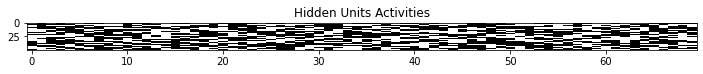

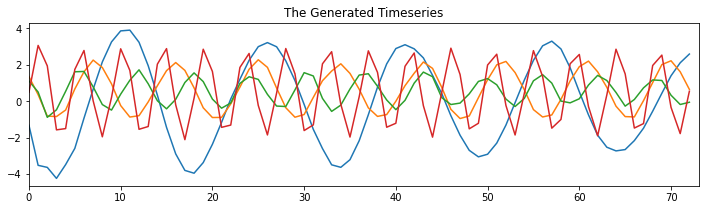

In [16]:
gen_sample, gen_hidden = generate(crbm, num_gen=70)

fig = plt.figure(figsize=(12, 0.5))
_= plt.imshow(gen_hidden.T, cmap='gray', interpolation='nearest', aspect='auto')
plt.title('Hidden Units Activities')

fig = plt.figure(figsize=(12, 3))
_ = plt.plot(gen_sample)        
plt.title('The Generated Timeseries')
plt.xlim(0,73)

sess.close()